In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from watertap3.truck_pipe_cost_functions import elevation,pipe_costing,truck_costing
import pprint

In [2]:
state_alpha = 'CO'

In [3]:
# Read the lcow file and the cluster lcow file

# Brackish water USGS files
bw_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_with_metrics_baseline_dwi_updated_costs_transport_updated_basis_1.csv')
PATH = r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Brackish\clustering_results\\' + state_alpha

cluster_df = pd.read_csv(PATH + '\\' + state_alpha.lower()+'_cluster.csv').drop(['Unnamed: 0'],axis=1)

In [4]:
idx = cluster_df['cluster_lcow'].idxmin()

In [5]:
# Get individual well treatment lcow
treatment_lcow = []
well_field_yield = []
well_field_lcow = []
brine_lcow = []
treatment_lcow_no_clustering = []
brine_lcow_no_clustering = []

# Iterate through each cluster and subcluster. Create list of well unique id
for cluster in cluster_df.cluster_id.unique():
    temp_df = cluster_df[cluster_df['cluster_id']==cluster]
    # print(cluster)
    for well_id in str(temp_df['unique_site_ID'].values[0]).split(','):
        # print(well_id)
        # print(bw_df[bw_df['unique_site_ID']==well_id]['treatment_lcow'].values[0])
        treatment_lcow.append(bw_df[bw_df['unique_site_ID']==well_id]['treatment_lcow'].values[0])
        well_field_yield.append(bw_df[bw_df['unique_site_ID']==well_id]['well_yield'].values[0])
        brine_lcow.append(bw_df[bw_df['unique_site_ID']==well_id]['pipe_lcow'].values[0])
    
    well_field_lcow.append(temp_df['cluster_avg_well_field_lcow'].values[0])
    treatment_lcow_no_clustering.append(np.average(treatment_lcow, weights=well_field_yield))
    brine_lcow_no_clustering.append(np.average(brine_lcow, weights=well_field_yield))

print(treatment_lcow_no_clustering)
print(well_field_lcow)
print(brine_lcow_no_clustering)

print('Clustered LCOW')
print(cluster_df['cluster_lcow'].values)


[0.8845064790000359, 0.9004125155761165, 0.8853256888061136, 0.8661694366022687, 0.8504181795635711, 0.8551972115229366]
[0.0588227391041394, 0.0402565746593132, 0.0431317332513154, 0.0443665811894174, 0.0435303252216118, 0.1397152852369927]
[0.10385708656298291, 0.11182887994055203, 0.1058735707541317, 0.09847843061278198, 0.09573609908194229, 0.09723477455258082]
Clustered LCOW
[0.96448707 1.14874144 0.98593773 0.9030897  0.84061652 1.77559799]


Text(0.5, 1.0, 'CO')

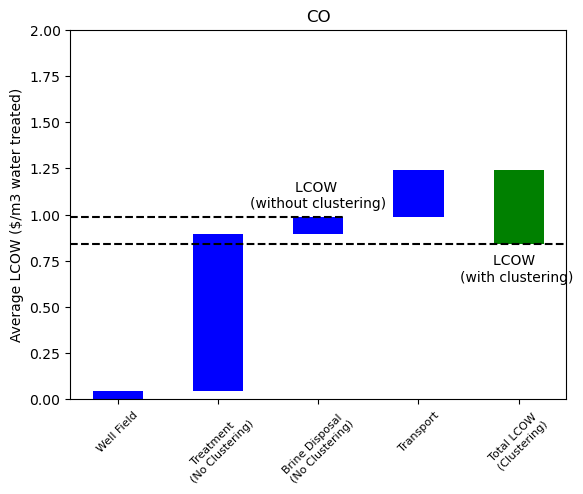

In [6]:
fig, ax = plt.subplots()

x = ['Well Field', 'Treatment \n(No Clustering)', 'Brine Disposal \n(No Clustering)', 'Transport', 'Total LCOW \n(Clustering)']

# Well Field
bottom = 0
ax.bar( x = x[0], height = well_field_lcow[idx], bottom=bottom, color='blue',width=0.5)

# Treatment
bottom = bottom + well_field_lcow[idx]             
ax.bar(x=x[1], height=treatment_lcow_no_clustering[idx], bottom = bottom, color='blue',width=0.5)
       
# Brine
bottom = bottom + treatment_lcow_no_clustering[idx]
ax.bar(x= x[2], height= brine_lcow_no_clustering[idx], bottom= bottom, color='blue',width=0.5)

# Total lcow if there was no cluster
ax.axhline(y = bottom + brine_lcow_no_clustering[idx],xmin=0, xmax=0.55, linestyle = '--',color ='black')
trans = ax.get_yaxis_transform()
plt.text(0.5,bottom + brine_lcow_no_clustering[idx]+0.05,'LCOW \n(without clustering)',
         transform=trans,horizontalalignment='center')

# Transport lcow in clustering
bottom = bottom + brine_lcow_no_clustering[idx]
ax.bar(x= x[3], height= (cluster_df['cluster_avg_pipe_well_subcluster_lcow'].values[idx] + cluster_df['cluster_avg_pipe_subcluster_cluster_lcow'].values[idx]),
            bottom = bottom, color='blue',width=0.5)

# Total LCOW in clustering
bottom = bottom + (cluster_df['cluster_avg_pipe_well_subcluster_lcow'].values[idx] + cluster_df['cluster_avg_pipe_subcluster_cluster_lcow'].values[idx])
height = min(cluster_df['cluster_lcow'].values) - bottom

ax.bar(x=x[4], height = height, bottom= bottom, color='green',width=0.5)

ax.axhline(y = cluster_df['cluster_lcow'].values[idx], linestyle = '--',color ='black')
trans = ax.get_yaxis_transform()
plt.text(0.9,cluster_df['cluster_lcow'].values[idx]-0.2,'LCOW \n(with clustering)',transform=trans,horizontalalignment='center')

ax.set_xticks(x,x,fontsize=8, rotation = 45)
ax.set_ylabel('Average LCOW ($/m3 water treated)')
ax.set_ylim([0,math.ceil(bottom)])

ax.set_title(state_alpha)

In [7]:
# Economy of scale including transport cost to the powerplant sector

In [8]:
# Trying optimization with Pyomo again
# 2 scenarios:
# 1. Total demand > BW available - Remove sum 1 constraint?
# 2. Total demand < BW available - This is straightforward

In [9]:
# Create matrix of brackish water sites (rows) and powerplant (columns) distance
from pyomo.environ import Var, Expression, NonNegativeReals, Block, ConcreteModel, Constraint, Objective, Param, maximize, SolverFactory,RangeSet
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock
from pyomo.util.infeasible import *
from idaes.core.util.model_statistics import *

In [10]:
# Check if demand or supply is greater
# state_alpha = 'CO'
pp_combined = pd.read_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Power\pp_combined_unclustered_' + state_alpha.lower()+'.csv')
pp_state = pp_combined[pp_combined['State']==state_alpha]
bw_state = bw_df[bw_df['state_alpha']==state_alpha]

print('Total well yield:', bw_state['well_yield'].sum())
print('Total demand:', pp_state['PPDemand'].unique().sum())

Total well yield: 7.930781630019851
Total demand: 1.8902317486466997


In [11]:
# Read clustered table

pp_combined_cluster = pd.read_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Power\pp_combined_clustered_'+state_alpha.lower()+'.csv')
pp_state_cluster = pp_combined_cluster[pp_combined_cluster['State']==state_alpha]

PATH = r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Brackish\clustering_results\\' + state_alpha
cluster_bw_df = pd.read_csv(PATH + '\\' + state_alpha.lower()+'_cluster.csv').drop(['Unnamed: 0'],axis=1)

In [23]:
# Assuming scenario 1 where Demand < BW available
# Function for no clustering

def build_input_no_cluster(bw_state_df,pp_state_df):

    no_bw_sites = len(bw_state_df)
    no_pp_sites = len(pp_state['PPDemand'].unique())

    dist = np.zeros((no_bw_sites,no_pp_sites))
    elev_gain_mat = np.zeros((no_bw_sites,no_pp_sites))
    pp_demand = []
    # Create array with brackish water availability
    bw_vol = []
    LCOW = []
    plantcode=[]

    i = 0
    j = 0 
    for pp in pp_state_df.index.unique():
        pp_demand.append(pp_state_df['PPDemand'].loc[pp].unique()[0])
        j=0
        for site in bw_state_df.index:
            dist[j,i] = pp_state_df[(pp_state_df['BWSites']==site)].loc[pp]['Distance_km']
            # trans_lcow[j,i] = pp_state_df[(pp_state_df['BWSites']==site)].loc[pp]['TransportLCOW']
            elev_gain= pp_state_df[(pp_state_df['BWSites']==site)].loc[pp]['PPElevation'] - pp_state_df[(pp_state_df['BWSites']==site)].loc[pp]['BWElevation']
            
            if elev_gain<0:
                elev_gain = 1e-5   

            elev_gain_mat[j,i] = elev_gain

            j=j+1

        i=i+1

    for site in bw_state_df.index:
        bw_available = bw_state_df['well_yield'].loc[site]*bw_state_df['recovery'].loc[site]/100
        bw_vol.append(bw_available)

        lcow = bw_state_df['lcow'].loc[site] + bw_state_df['well_field_lcow'].loc[site]/(bw_state_df['recovery'].loc[site]/100)
        
        LCOW.append(lcow)
    
    return [bw_vol,pp_demand,LCOW,elev_gain_mat,dist,bw_state_df['elec_price'].loc[site]]

def build_input_cluster(bw_state_df,pp_state_df):

    no_bw_sites = len(bw_state_df)
    no_pp_sites = len(pp_state['PPDemand'].unique())

    dist = np.zeros((no_bw_sites,no_pp_sites))
    elev_gain_mat = np.zeros((no_bw_sites,no_pp_sites))
    pp_demand = []
    # Create array with brackish water availability
    bw_vol = []
    LCOW = []
    plantcode=[]

    i = 0
    j = 0 
    for pp in pp_state_df.index.unique():
        pp_demand.append(pp_state_df['PPDemand'].loc[pp].unique()[0])
        j=0
        for site in bw_state_df.index:
            dist[j,i] = pp_state_df[(pp_state_df['BWSites']==site)].loc[pp]['Distance_km']
            # trans_lcow[j,i] = pp_state_df[(pp_state_df['BWSites']==site)].loc[pp]['TransportLCOW']
            elev_gain = pp_state_df[(pp_state_df['BWSites']==site)].loc[pp]['PPElevation'] - bw_state_df['centroid_elev'].loc[site]

            if elev_gain<0:
                elev_gain = 1e-5   

            elev_gain_mat[j,i] = elev_gain
            
            j=j+1

        i=i+1

    for site in bw_state_df.index:
        bw_available = bw_state_df['cluster_total_well_yield'].loc[site]*bw_state_df['recovery'].loc[site]/100
        bw_vol.append(bw_available)

        lcow = bw_state_df['cluster_lcow'].loc[site]
        
        LCOW.append(lcow)
    
    return [bw_vol,pp_demand,LCOW,elev_gain_mat,dist,bw_state_df['elec_price'].loc[site]]


def try_cool_matrix(bw_vol,demand,lcow,elev_gain,dist,elec_rate):

    m = ConcreteModel()
    m.I = pyo.Set(initialize = range(dist.shape[0]))
    # powerplant site index
    m.J = pyo.Set(initialize = range(dist.shape[1]))

    m.matrix= pyo.Set(initialize = m.I*m.J)
    m.x = Var(m.matrix, domain=NonNegativeReals, bounds= (0,1))

    m.constraints= pyo.ConstraintList()

    # Sum of fractions should be less than or equal to 1
    for i in m.I:
        m.constraints.add((sum(m.x[i,j] for j in m.J)) <= 1 )
    
    # Production to be as close to maximum as possible
    for j in m.J:
       m.constraints.add((sum((m.x[i,j]*float(bw_vol[i])) for i in m.I)) >= float(demand[j]))

    # for j in m.J:
    #     m.constraints.add((sum(( LCOW[i]*m.x[i,j] + transport_cost(bw_vol[i],dist[i,j])*m.x[i,j] ) for i in m.I)) <= 2)

    # def obj_demand(m):
    #     return sum(sum(m.x[i,j]*float(bw_vol[i]) for i in m.I) for j in m.J)
    

    # LCOW objective
    def obj(m):
        total_supply = sum(sum((bw_vol[i]*m.x[i,j]) for i in m.I) for j in m.J)

        treatment_lcow =  sum(sum(bw_vol[i]*lcow[i]*m.x[i,j] for i in m.I) for j in m.J)/total_supply

        # supply = m.x
        # for i in m.I:
        #     for j in m.J:
        #         supply[i,j] = bw_vol[i]*m.x[i,j]

        transport_lcow =  sum(sum((bw_vol[i]*m.x[i,j]*pipe_costing(bw_vol[i]*3600*24,
                                                                   dist[i,j],
                                                                   elev_gain = elev_gain[i,j],
                                                                electricity_rate=elec_rate)) for i in m.I) for j in m.J)/total_supply
                              
        return treatment_lcow + transport_lcow
    
    # m.obj2 = Objective(rule=obj_demand,sense = pyo.maximize)
    m.obj1 = Objective(rule = obj)

    solver = SolverFactory('ipopt')
    results = solver.solve(m)

    return m

def opt_check_cluster(bw_state,pp_state,cluster = 0):
    if cluster == 0:
        bw_state_df = bw_state.set_index('unique_site_ID')
        pp_state_df = pp_state.set_index('PlantCode')
        [bw_vol,pp_demand,LCOW,elev_gain,dist,elec_rate] = build_input_no_cluster(bw_state_df,pp_state_df)
    
    else:
        bw_state_df = bw_state.set_index('cluster_id')
        pp_state_df = pp_state.set_index('PlantCode')
        [bw_vol,pp_demand,LCOW,elev_gain,dist,elec_rate] = build_input_cluster(bw_state_df,pp_state_df)
    
    solver = SolverFactory('ipopt')
    
    m = try_cool_matrix(bw_vol,pp_demand,LCOW,elev_gain,dist,elec_rate)

    dict = (m.x.get_values())

    x = np.zeros(dist.shape)

    for i,j in dict.keys():
        x[i,j] = dict[(i,j)]

    supply = (np.array(x).T * np.array(bw_vol))

    results = pd.DataFrame(supply,columns=bw_state_df.index.unique(),index=pp_state_df.index.unique())

    return [m,results,x,bw_vol,supply,LCOW]


In [24]:
m,results,x,bw_vol,supply,lcow = opt_check_cluster(bw_state,pp_state,cluster=0)

print(m.obj1())

1.6307800909475811


In [34]:
I = len(bw_state)
J = len(pp_state['PlantCode'].unique())

total_supply = sum(sum((bw_vol[i]*x[i,j]) for i in range(I)) for j in range(J))

treatment_cost = sum(sum((bw_vol[i]*lcow[i]*x[i,j]) for i in range(I)) for j in range(J))/total_supply
# transport_cost = sum(sum((bw_vol[i]*trans_lcow[i,j]*x[i,j]) for i in range(I)) for j in range(J))/total_supply

print('Treatment LCOW:',treatment_cost)
# print('Transport LCOW:',transport_cost)
# print('LCOW:', treatment_cost+transport_cost)

Treatment LCOW: 0.8962206091949072


In [42]:
m,results,x,bw_vol,supply,lcow = opt_check_cluster(cluster_bw_df,pp_state_cluster,cluster=1)
print(m.obj1())

0.9190787785047376


In [37]:
I = len(cluster_bw_df)
J = len(pp_state_cluster['PlantCode'].unique())

total_supply = sum(sum((bw_vol[i]*x[i,j]) for i in range(I)) for j in range(J))

treatment_cost = sum(sum((bw_vol[i]*lcow[i]*x[i,j]) for i in range(I)) for j in range(J))/total_supply
# transport_cost = sum(sum((bw_vol[i]*trans_lcow[i,j]*x[i,j]) for i in range(I)) for j in range(J))/total_supply

print('Treatment LCOW:',treatment_cost)
# print('Transport LCOW:',transport_cost)
# print('LCOW:', treatment_cost+transport_cost)


Treatment LCOW: 0.9118638707859287


In [51]:
# results.to_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Power\optimization_attempt\\'+state_alpha.lower() +'_no_clustering.csv')